# Tests on long acquisition

The notebook contains some basics information regarding the acquisition and reconstruction from cryoscope.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import cma

from scipy.optimize import least_squares, minimize, Bounds
from pathlib import Path

from cryoscope_scripts import _fit, load_cryoscope_data

from qibocal.protocols.two_qubit_interaction.cryoscope import CryoscopeResults

from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
    iter_filter_application,
)

from tools import (
    plot_reconstructed_data,
    plot_signal_filtered,
    plot_signal_filtered_iter,
    Signal,
)

DIRECT = False
DATA_START = 0
POLYORDER = 2
PHASE_SCALING = 2 * np.pi
MODE = "nearest"

[Qibo 0.2.12|INFO|2024-12-17 16:30:26]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-17 16:30:26]: Loading platform dummy


In [2]:
def buildplot(
    data: list[float], color: str, label: str, title: str, save: bool, folder: str
):
    plt.figure(figsize=(12, 6))
    plt.plot(data, color=color, label=label)
    plt.xlabel("time [ns]")
    plt.ylabel("Signal")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()


In [7]:
data_path = (Path.cwd().parent/ "cryo_material"/ "long_acquisition" / "data" / "cryoscope-0")

data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)
flux_amplitude = data['"flux_pulse_amplitude"']

cryoscope_data = load_cryoscope_data(data_path / "data.npz", 0.5)

cryoscope_results, raw_detuning, phase = _fit(
    cryoscope_data, savgol=True, demod=True, window_length=7, causal=False
)

_, _, no_savgol_no_demod = _fit(cryoscope_data, savgol=False, demod=False, window_length=7, causal=False)
_, _ ,no_savgol_demod = _fit(cryoscope_data, savgol=False, demod=True, window_length=7, causal=False)

t = np.arange(0, 99, 1)
start = 10

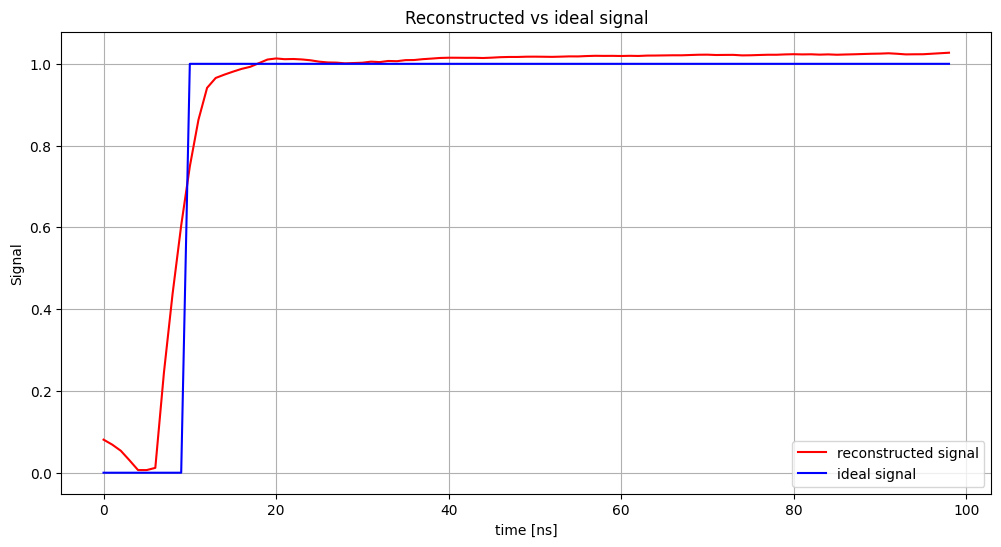

<module 'matplotlib.pyplot' from '/home/elisa/.pyenv/versions/calibration/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [8]:
plot_reconstructed_data(cryoscope_results, "D1", DATA_START, t, start)

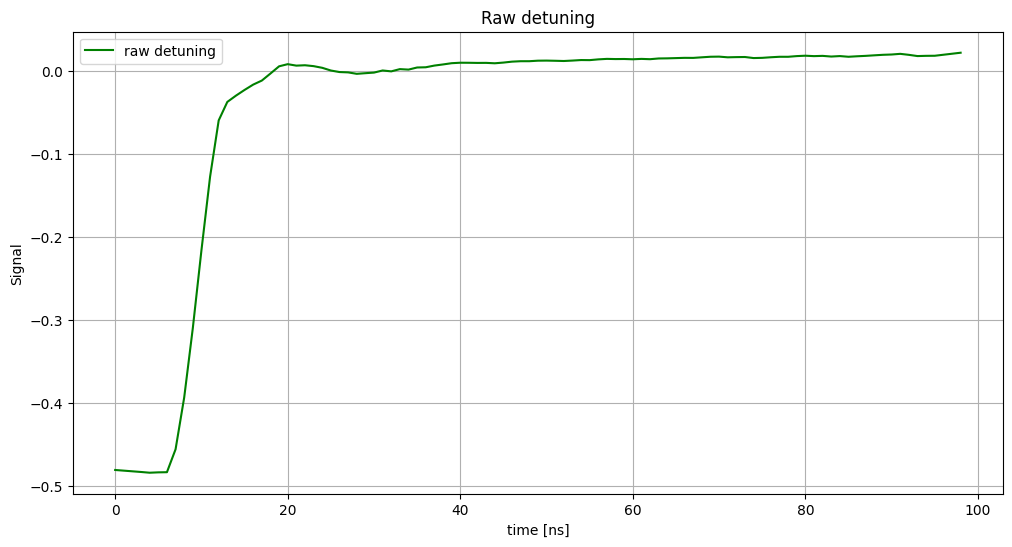

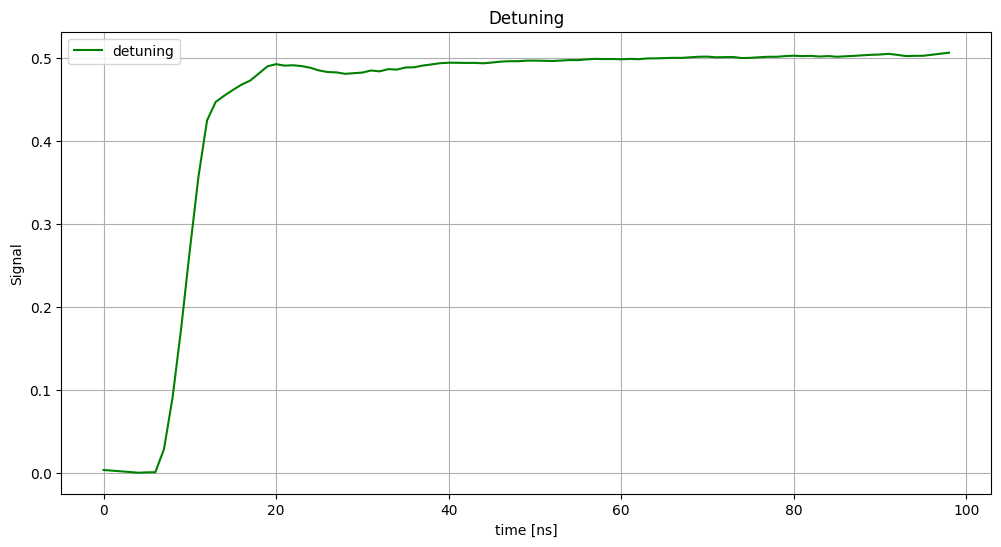

In [9]:
buildplot(data=raw_detuning, color="green", label="raw detuning", title="Raw detuning", save=False, folder="no_demod")
buildplot(data=cryoscope_results.detuning["D1"], color="green", label="detuning", title="Detuning", save=False, folder="no_demod")

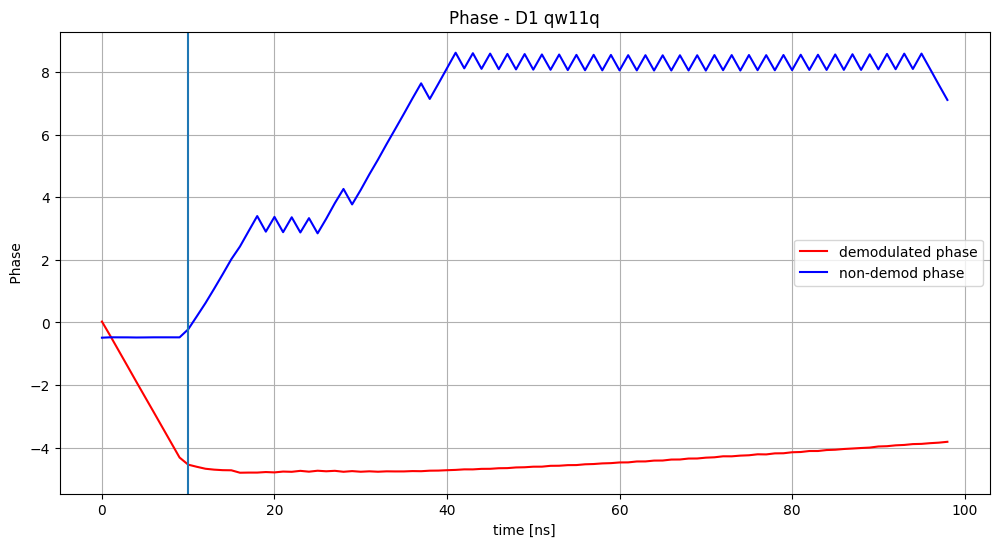

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(no_savgol_demod, color="red", label="demodulated phase")
plt.plot(no_savgol_no_demod, color="blue", label="non-demod phase")
plt.axvline(x=10)
plt.xlabel("time [ns]")
plt.ylabel(" Phase ")
plt.title("Phase - D1 qw11q")
plt.legend()
plt.grid()
plt.show()